In [1]:
!git clone https://github.com/AbdullahAbdelaziz122/EmotionDetection.git


fatal: destination path 'EmotionDetection' already exists and is not an empty directory.


Loading Data

In [2]:
import time
import datetime

In [3]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split


train_dir = './EmotionDetection/archive/train'
test_dir = './EmotionDetection/archive/test'
img_size = 48
## Load images from the data directory

def load_images(data_dir, img_size):
    images = []
    labels = []
    label_map = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'sad': 4, 'surprised': 5, 'neutral': 6}

    for label in label_map:
        label_dir = os.path.join(data_dir, label)
        if not os.path.exists(label_dir):
            print(f"Directory {label_dir} does not exist.")
            continue
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label_map[label])
            else:
                print(f"Failed to load image: {img_path}")

    images = np.array(images) / 255.0  # Normalize pixel values
    images = np.expand_dims(images, -1)  # Add a channel dimension
    labels = np.array(labels)

    return images, labels

def split_data(X_train, y_train):
    X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_val, X_test, y_val, y_test


# Load training and test data
X_train, y_train = load_images(train_dir, img_size)
X_test, y_test = load_images(test_dir, img_size)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Training data shape: (28709, 48, 48, 1), Training labels shape: (28709,)
Test data shape: (7178, 48, 48, 1), Test labels shape: (7178,)


In [4]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')  # 7 emotion classes
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [5]:
def train_model(data_dir, img_size, epochs, batch_size, X_train, X_test, y_train, y_test):
  """
  Trains a CNN model for emotion detection.

  Args:
      data_dir: Path to the directory containing the image data (unused in this case).
      img_size: Desired image size for preprocessing.
      epochs: Number of training epochs.
      batch_size: Batch size for training.
      X_train: Training images.
      X_test: Testing images.
      y_train: Training labels.
      y_test: Testing labels.

  Returns:
      The training history object.
  """

  input_shape = (img_size, img_size, 1)
  cnn_model = create_model(input_shape)  # Assuming create_model is defined elsewhere

  history = cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

  cnn_model.save(f'emotion_detection_model_h5')  # Consider including date in filename
  return history


In [11]:
import tensorflow as tf

def evaluate_model():
    X_train, y_train = load_images(train_dir, img_size)
    X_test, y_test = load_images(test_dir, img_size)
    X_val, X_test, y_val, y_test = split_data(X_train, y_train)
    input_shape = (img_size, img_size, 1)
    cnn_model = create_model(input_shape)  # Assuming create_model is defined elsewhere
    cnn_model.load_weights('emotion_detection_model_h5')
    val_loss, val_acc = cnn_model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {val_acc}")
    test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc}")
    return val_acc, test_acc

In [7]:
import tensorflow as tf
import cv2
import numpy as np

def predict_emotion(model_path, img_path, img_size):
    model = tf.keras.models.load_model(model_path)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = img[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

    prediction = model.predict(img)
    emotion = np.argmax(prediction)

    emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    return emotion_dict[emotion]


In [8]:
# Parameters
data_dir = '/content/EmotionDetection/archive'
img_size = 48
epochs = 50
batch_size = 64

# Train the model

history = train_model(data_dir, img_size, epochs, batch_size, X_train, X_test, y_train, y_test)




Epoch 1/50
449/449 [==============================] - 13s 13ms/step - loss: 1.9573 - accuracy: 0.3228 - val_loss: 1.7778 - val_accuracy: 0.2944
Epoch 2/50
449/449 [==============================] - 6s 13ms/step - loss: 1.4951 - accuracy: 0.4265 - val_loss: 1.3981 - val_accuracy: 0.4684
Epoch 3/50
449/449 [==============================] - 5s 11ms/step - loss: 1.3704 - accuracy: 0.4778 - val_loss: 1.3345 - val_accuracy: 0.4854
Epoch 4/50
449/449 [==============================] - 5s 11ms/step - loss: 1.3144 - accuracy: 0.4989 - val_loss: 1.4701 - val_accuracy: 0.4526
Epoch 5/50
449/449 [==============================] - 6s 12ms/step - loss: 1.2744 - accuracy: 0.5188 - val_loss: 1.1893 - val_accuracy: 0.5411
Epoch 6/50
449/449 [==============================] - 5s 11ms/step - loss: 1.2323 - accuracy: 0.5298 - val_loss: 1.2002 - val_accuracy: 0.5412
Epoch 7/50
449/449 [==============================] - 6s 13ms/step - loss: 1.2030 - accuracy: 0.5436 - val_loss: 1.2158 - val_accuracy: 0.542

In [13]:

#Evaluate the model
val_acc, test_acc = evaluate_model()



718/718 [==============================] - 3s 3ms/step - loss: 0.5486 - accuracy: 0.8092
Validation Accuracy: 0.8092480301856995
180/180 [==============================] - 1s 3ms/step - loss: 0.5527 - accuracy: 0.8060
Test Accuracy: 0.8059909343719482


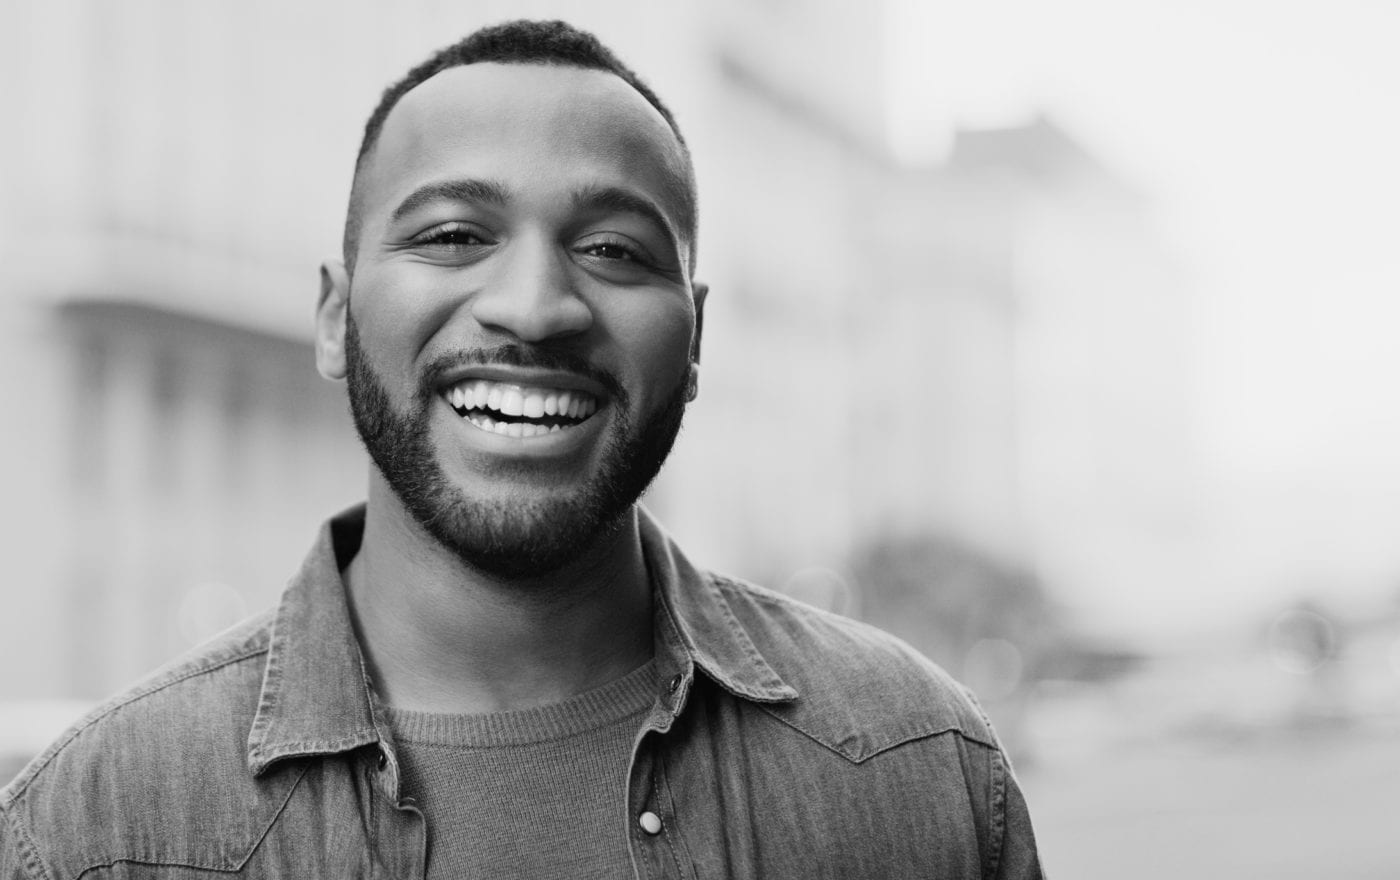

-1

In [28]:
# Show and load new image
img_path = '/content/05-12-21-happy-people.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Import the necessary patch for displaying images in Colab
from google.colab.patches import cv2_imshow

cv2_imshow(img) # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)

In [29]:
#Predict emotion for a new image
model_path = 'emotion_detection_model_h5'
emotion = predict_emotion(model_path, img_path, img_size)
print(f'Predicted Emotion: {emotion}')

1/1 [==============================] - 0s 164ms/step
Predicted Emotion: Surprise
